# Group Work Submission 3 : Simulate Asset Price Evolutions and Reprice Risky up-and-out Call Option

## Team Members Name.

- Xin He (xinhe9701@gmail.com)
- Ali Kone (ali.kone18@rotman.utoronto.ca)
- David Akanji (david.o.akanji@gmail.com)



In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize
import math
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import matplotlib.pyplot as plt
%matplotlib inline

# Question 1



##### Initializing the Parameters

In [2]:
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money
v_0 = 200 # counterparty firm current value
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 1000000
sigma_const = 0.30
gamma = 0.75


#### 1.1 Calibrating LIBOR foward rate model using the Zero Coupon Bond

We would start by initilizing the given zero coupon bond price, and then went on by creating a function that will calculate the simulated bond prices from the Vasicek model.

In [3]:
t = np.linspace(0,1,13)

market_zcb_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516,
       0.9457, 0.9399, 0.9342, 0.9285])

Also we define the helper function A and D as well as function F which measures the differences between the calculated bond price from our model and the zero coupon prices of the actual market.

In [4]:
def A(t1, t2, alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha


def D(t1, t2, alpha, b, sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r+D(t,T,alpha,b,sigma))


def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum(np.abs(bond_price_fun(r0,0,t,alpha,b,sigma)-market_zcb_prices))

In [5]:
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00025649906704716674
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


We calculate also the optimal parameters of the model using a minimum value of `F`. This is done using the function ` fmin_slsqp` from `scipy` library.

In [6]:
alpha_min, alpha_max = (0,1)
b_min, b_max = (0,0.2)
sigma_min, sigma_max = (0,0.2)
r_min, r_max = (0.00, 0.10)

alpha_0 = 0.3
b_0 = 0.05
sigma_0 = 0.05
r_0 = 0.05

bnds = ((alpha_min, alpha_max),(b_min, b_max),(sigma_min, sigma_max), (r_min, r_max))
opt_val = scipy.optimize.fmin_slsqp(F, (alpha_0, b_0, sigma_0, r_0), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0002460944580424673
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [7]:
print("Optimal Alpha: {:.3f}".format(opt_val[0]))
print("Optimal B: {:.3f}".format(opt_val[1]))
print("Optimal Sigma {:.3f}".format(opt_val[2]))
print("Optimal R0: {:.3f}".format(opt_val[3]))

Optimal Alpha: 0.274
Optimal B: 0.071
Optimal Sigma 0.045
Optimal R0: 0.075



Deriving the model bond price and plotting the market actual bond price

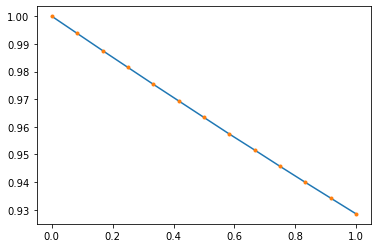

In [8]:
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sigma)
model_yield = -np.log(model_prices)/t

market = plt.plot(t,market_zcb_prices, label='Market Prices')
model = plt.plot(t, model_prices, '.', label='Calibrated Prices')
plt.show();
#plt.legend();


From the plot above we can deduce there is a close fit from the plot

### 1.2. Simulating the  LIBOR Rate Paths

The first approach here is to initialize a parameter $\sigma_j$ and then use the obtained parameter above to simulate the  Vasicek bond prices

In [9]:
sigmaj = 0.2

vasi_bond = bond_price_fun(opt_r0, 0, t, alpha=opt_alpha, b=opt_b, sigma=opt_sigma)
print(f"The bond prices according to Vasicek Model is {vasi_bond}")

The bond prices according to Vasicek Model is [1.         0.9937799  0.98760628 0.98147965 0.97540042 0.96936895
 0.96338548 0.95745024 0.95156334 0.94572488 0.93993486 0.93419326
 0.9285    ]


We are initilizing the arrays that will store the simulation of Predictor Corrector and Monte Carlo method then running the Monte Carlo simulation for each timestamp

In [10]:
n_simulations = sample_size
n_steps = len(t)

delta = np.ones([n_simulations, n_steps - 1])*(t[1:]-t[:-1])
mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(delta*vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(delta*vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])


for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    
    muhat = np.cumsum(delta[:, i:]*mc_forward[:, i:]*sigmaj**2/(1+delta[:, i:]*mc_forward[:,i:]), axis=1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]), axis=1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp), axis=1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)


Calculating the the `bond prices and capitalization factor` from the Monte carlo simulation. Also plotting of `bond prices and capitalization factor` against `Vasicek bond prices.` for comparison

In [11]:
mc_capfac[:,1:] = np.cumprod(1 + delta * mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1+ delta * predcorr_forward, axis=1)

mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)

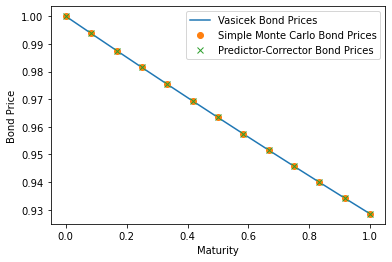

In [12]:
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,vasi_bond, label="Vasicek Bond Prices")

plt.plot(t, mc_final, 'o', label="Simple Monte Carlo Bond Prices")
plt.plot(t, predcorr_final, 'x', label="Predictor-Corrector Bond Prices")
plt.legend()
plt.show();

In our simulation, we used Predictor Corrector approach, $e^{r_{t_i} (t_{i+1}-t_i)} = 1 + L(t_i,t_{i+1})(t_{i+1}-t_i)$ in order to calculate the continuous compounded interest rates

In [13]:
r_sim = np.log(1 + predcorr_forward*delta)

In [14]:
r_annualized= lambda r: pd.DataFrame((1+r*delta)**len(t-1)-1)

In [15]:
r_sim_annualized = r_annualized(r_sim)


Calculting the annualized interest rate

In [16]:
r_sim_annualized

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.006781,0.006875,0.006681,0.006280,0.006179,0.007163,0.006891,0.007080,0.007634,0.007413,0.006554,0.007138
1,0.006781,0.006546,0.006754,0.007460,0.008101,0.007581,0.007584,0.008525,0.008051,0.008545,0.007788,0.007547
2,0.006781,0.006794,0.006389,0.006633,0.007340,0.007484,0.006885,0.006628,0.007580,0.007107,0.007497,0.007317
3,0.006781,0.006728,0.006711,0.006551,0.006046,0.006165,0.006153,0.006308,0.006208,0.006027,0.005546,0.005290
4,0.006781,0.006847,0.007130,0.006898,0.007730,0.008023,0.008183,0.007827,0.007827,0.007756,0.008060,0.007775
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.006781,0.006607,0.006838,0.007196,0.007282,0.007142,0.006825,0.006438,0.006315,0.005767,0.005854,0.005761
999996,0.006781,0.006436,0.006506,0.006609,0.006299,0.005966,0.006101,0.006268,0.005841,0.005636,0.005955,0.006530
999997,0.006781,0.006549,0.005866,0.005693,0.005435,0.005137,0.004957,0.005392,0.005624,0.005681,0.005328,0.005300
999998,0.006781,0.006673,0.007380,0.007348,0.007176,0.007727,0.007866,0.008094,0.008160,0.007296,0.007751,0.007667


### 1.3. Generating a Stock and Firm Values

Computing the correlated path using the Cholesky decomposition


In [17]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):
    
    sigma= sigma_const*(prev_price)**(gamma-1) if varying_vol else sigma_const*(S0)**(gamma-1)
    
    return prev_price*np.exp(np.cumsum((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z,1))

def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])
    share_price_path = share_price_path.reset_index(drop=True)

    firm_price_path = pd.DataFrame(next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])
    firm_price_path = firm_price_path.reset_index(drop=True)

    return [share_price_path,firm_price_path]  
share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, r_sim_annualized, sigma_const, gamma, corr, T, sample_size, timesteps = 12)

In [18]:
share_prices.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,999985,999986,999987,999988,999989,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,101.222293,98.308881,102.142481,103.415313,98.353934,98.941445,99.328350,96.650859,101.548003,97.125148,98.360400,97.751549,98.804050,96.929176,99.087147,...,98.949082,98.421317,103.109629,97.789595,101.025721,98.385859,101.427013,100.347988,98.103969,97.764627,95.765991,100.239518,96.346069,101.571910,99.055524
2,99.305163,98.214245,106.524409,103.699119,94.618722,100.577035,103.432336,96.039834,105.424254,97.282575,93.646083,98.383091,103.431273,97.745380,99.972856,...,97.570385,97.222639,102.500993,96.081954,103.351242,95.155861,97.404166,99.137873,100.202853,91.513084,95.986846,100.019841,98.302447,98.105776,103.434628
3,98.371558,99.034430,107.728380,103.525896,97.550015,102.964222,103.363607,98.993564,103.010607,94.702834,95.880349,97.530614,102.428379,96.497785,98.678546,...,95.801477,93.337204,104.626343,90.652937,104.483719,97.250243,94.896772,98.765549,99.555394,85.258175,97.366499,106.223550,99.528618,103.089578,105.760711
4,98.771258,95.686788,105.365429,102.566632,92.589683,104.449129,102.678331,98.150212,99.928006,95.407638,93.996984,101.515753,99.623479,94.409980,100.392322,...,94.190670,97.071488,103.594356,88.571172,104.396178,101.804122,92.459064,95.306170,100.900286,84.897353,93.985182,109.381099,105.988331,98.162561,111.005666


In [19]:
firm_prices.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,999985,999986,999987,999988,999989,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,200.482827,204.823328,207.073623,205.180220,201.921571,200.636476,193.990904,193.014105,194.765118,194.027143,198.060605,194.189874,198.951503,194.930119,202.641183,...,195.771265,199.251457,196.584961,202.368451,196.996237,203.405326,196.650640,198.594573,202.356294,203.845284,190.102657,204.738296,193.749484,199.331173,203.008684
2,202.966262,199.796309,203.606607,210.916836,203.809283,207.135489,195.643606,190.290819,196.160095,189.967348,191.869983,198.423594,201.453161,197.395137,200.808503,...,201.791735,200.024205,200.217668,193.140512,198.786109,204.849529,201.654828,194.346793,211.783536,197.698889,184.070466,206.184251,198.677502,199.312892,211.040974
3,210.673702,200.716658,196.627781,213.424769,203.830334,199.677920,192.409256,196.304576,189.729836,189.657431,194.532721,193.755602,201.964574,201.304373,202.973721,...,198.782698,199.485161,196.750070,186.981132,198.893264,208.142660,198.945500,190.180904,209.919046,188.198520,187.561582,210.922463,198.051778,205.445991,205.442922
4,211.298155,207.349125,198.502736,213.816088,200.384332,196.147860,194.102222,190.740520,189.549389,187.921010,194.165163,198.484222,196.026776,202.054601,197.232516,...,195.350511,197.242340,194.470386,189.379068,206.675189,201.660772,203.254389,191.832671,208.697762,188.042405,184.041132,210.244401,202.165875,209.785763,204.425512


### Ploting the Stock price and the firm value path simulated for 100 simulations

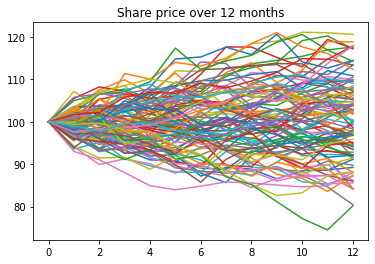

In [20]:
share_prices.iloc[:,0:100].plot(title='Share price over 12 months', legend=False);

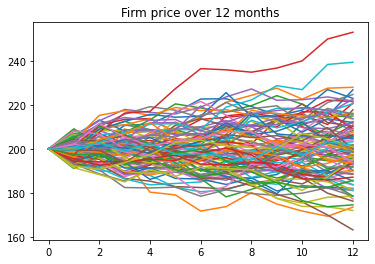

In [21]:
firm_prices.iloc[:,0:100].plot(title='Firm price over 12 months', legend=False);

# Question 2


### 1 - Year discount factor

In [22]:
def discount_factor(r):
    return  1/np.cumprod(1 + r,1)[:,-1]

In [23]:
one_year_disc_fac = discount_factor(r_sim)

print(f"The one year discount factor is {one_year_disc_fac}")


The one year discount factor is [0.92697732 0.91975216 0.92548555 ... 0.93969089 0.9208753  0.92992473]


### Defining Payoff and pricing function for up-and-out call option

In [24]:
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

In [25]:
def option_price(S0:float, K:float, L: float, r:float, cva_adjust:bool=True):
    annualized_rate = r_annualized(r)
    generate_share_and_firm_price(S0, v_0, annualized_rate, 
                                sigma_const, gamma, corr, T, 
                                sample_size, timesteps = 12)[0]
    payoffs = payoff(share_prices, K, L)
    option_prices = discount_factor(r)*payoffs
    cva = 0
    
    # Factor the CVA adjustment in the option prices
    if cva_adjust:
        firm_prices = generate_share_and_firm_price(S0, v_0, annualized_rate, 
                                                    sigma_const, gamma, corr, T, 
                                                    sample_size, timesteps = 12)[1]
        term_firm_vals = firm_prices.iloc[-1].to_numpy()
        cva_estimates = discount_factor(r)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
        option_prices -= cva_estimates
        cva += cva_estimates.mean()
    option_price_est = option_prices.mean()
    option_std_est = option_prices.std()/np.sqrt(len(payoffs))
    
    return option_price_est, option_std_est,cva
    

### Estimating the default-free value of the option

In [26]:
option_price_est, option_std_est, _ = option_price(S0, K, L, r_sim, cva_adjust=False)
print("Default-free option price {:.3f}".format(option_price_est))
print("Default-free option price standard deviation {:.3f}".format(option_std_est))

Default-free option price 3.850
Default-free option price standard deviation 0.006


### Estimating the value of option with counterparty credit risk

In [27]:
option_cva_adjusted_prices, option_cva_adjusted_std, cva_estimate = option_price(S0, K, L, r_sim, cva_adjust=True)
print("CVA-adjusted option price {:.3f}".format(option_cva_adjusted_prices))
print("CVA-adjusted option price standard deviation {:.3f}".format(option_cva_adjusted_std))
print("Credit value adjustment {:.3f}".format(cva_estimate))

CVA-adjusted option price 3.726
CVA-adjusted option price standard deviation 0.006
Credit value adjustment 0.125


## Question 3

The credit risk of the long party in the option would increase the value of the option through the decrease of the Bilateral CVA

## Question 4 : Impact of an increase of interest rates of 25 bps on the option prices

We assume that the interest rate is increased by 25 bps during each time step

In [28]:
r_sim += 0.25/100

In [29]:
option_price_est, option_std_est, _ = option_price(S0, K, L, r_sim, cva_adjust=False)
print("The Default-free option price after a monthly rate increase of 25 bps is: {:.3f}".format(option_price_est))
print("Default-free option price standard deviation after a monthly rate increase of 25 bps is: {:.3f}".format(option_std_est))

The Default-free option price after a monthly rate increase of 25 bps is: 3.737
Default-free option price standard deviation after a monthly rate increase of 25 bps is: 0.006


In [30]:
option_cva_adjusted_prices, option_cva_adjusted_std, cva_estimate = option_price(S0, K, L, r_sim, cva_adjust=True)
print("CVA-adjusted option price after a monthly rate increase of 25 bps is: {:.3f}".format(option_cva_adjusted_prices))
print("CVA-adjusted option price standard deviation after a monthly rate increase of 25 bps is: {:.3f}".format(option_cva_adjusted_std))
print("Credit value adjustment after a monthly rate increase of 25 bps is: {:.3f}".format(cva_estimate))

CVA-adjusted option price after a monthly rate increase of 25 bps is: 3.626
CVA-adjusted option price standard deviation after a monthly rate increase of 25 bps is: 0.005
Credit value adjustment after a monthly rate increase of 25 bps is: 0.112
